In [126]:
import numpy as np
import pylab as plt
import soundfile as sf
import pandas as pd

from scipy import signal
from IPython.display import Audio, display

FS = 44100
SLC = slice(4*FS, 8*FS)


def play(x, fs=FS):
    display(Audio(x, rate=fs, normalize=False))
    
plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["figure.dpi"] = 150
plt.rcParams['axes.grid'] = True

In [127]:
instruments = ['drum', 'bass', 'vocal', 'guitar']
gain = {'drum': 0.9, 'bass': 0.3, 'vocal': 0.5, 'guitar': 0.1}

/var/folders/0_/r7l1mtgn2yx393q7lsf3bp7c0000gn/T/ipykernel_96097/3293663392.py:7: RuntimeWarning: divide by zero encountered in log
  ax[1].pcolormesh(t, f, np.log(Sxx), cmap='nipy_spectral', shading='auto')


array([0., 0., 0., ..., 0., 0., 0.])

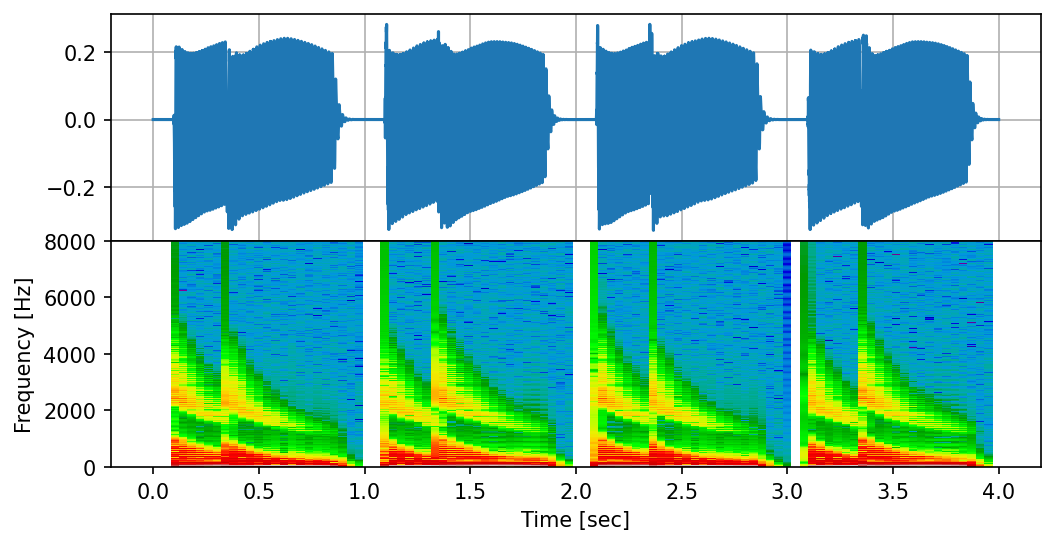

In [135]:
def show_sound(x):
    fig, ax = plt.subplots(2, figsize=(8,4), dpi=150, sharex=True)
    plt.subplots_adjust(hspace=0)
    ax[0].plot(np.arange(len(x))/FS, x)

    f, t, Sxx = signal.spectrogram(x, FS, nperseg=2000)
    ax[1].pcolormesh(t, f, np.log(Sxx), cmap='nipy_spectral', shading='auto')
    ax[1].set_ylabel('Frequency [Hz]')
    ax[1].set_xlabel('Time [sec]')
    ax[1].set_ylim([0, 8000])
    play(x)

def load_source(name, slc=SLC, show=False):
    x, _fs = sf.read('../data/{}.wav'.format(name))
    x = x[slc, 0]/np.max(x[:, 0])
    x = x * gain[name]
    if show:
        show_sound(x)
    return x
    
load_source('bass', show=True)

In [137]:
sources = np.vstack([load_source(inst) for inst in instruments]).T

print(sources.shape)
pd.DataFrame(sources, columns=instruments)


(176400, 4)


,drum,bass,vocal,guitar
0,-0.001173,0.0,0.000000,0.005631
1,-0.000744,0.0,0.000000,0.006934
2,-0.000401,0.0,0.000000,0.008069
3,-0.003434,0.0,0.000000,0.008878
4,-0.005238,0.0,0.000000,0.009290
...,...,...,...,...
176395,-0.003721,0.0,-0.000982,-0.017093
176396,-0.005209,0.0,-0.000982,-0.013327
176397,-0.005295,0.0,-0.000962,-0.009720
176398,-0.006068,0.0,-0.000962,-0.006699


In [41]:
center_spatial_filter = np.ones(4)/4
center_spatial_filter

array([0.25, 0.25, 0.25, 0.25])

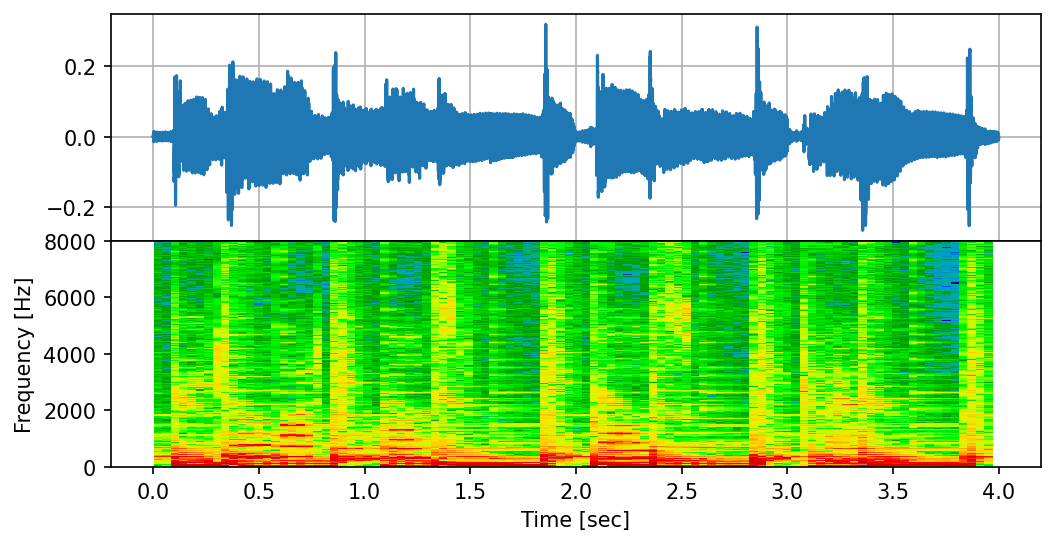

In [138]:
center_micro = sources.dot(center_spatial_filter)
show_sound(center_micro)

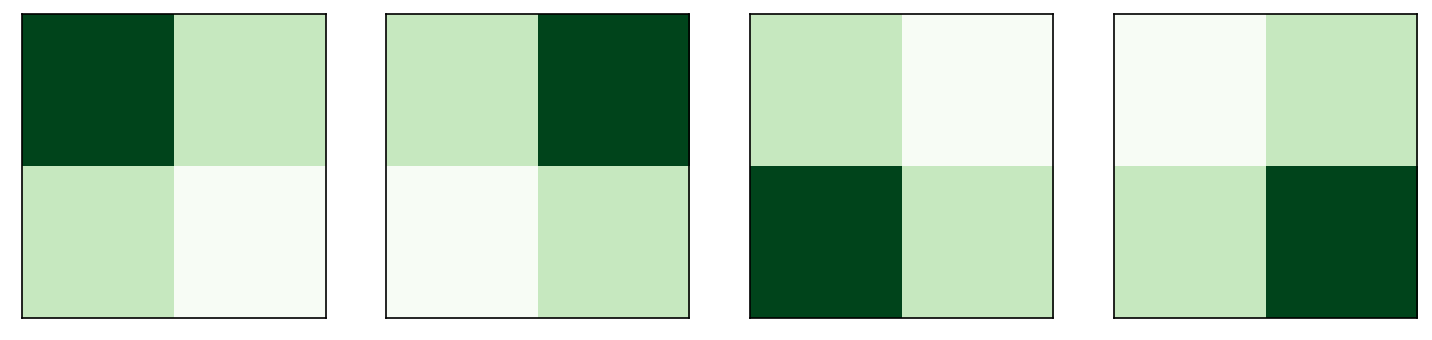

In [139]:
mixing = np.array([
    [0.5, 0.2, 0.2, 0.1],
    [0.2, 0.5, 0.1, 0.2],
    [0.2, 0.1, 0.5, 0.2],
    [0.1, 0.2, 0.2, 0.5]
])

def plot_top(filt):
    fig, ax = plt.subplots(1, 4, figsize=(12, 3), dpi=150, sharex=True)
    for s in range(4):
        ax[s].imshow(filt[:, s].reshape(2,2), cmap='Greens')
        ax[s].set_xticks([])
        ax[s].set_yticks([])
    
plot_top(mixing)

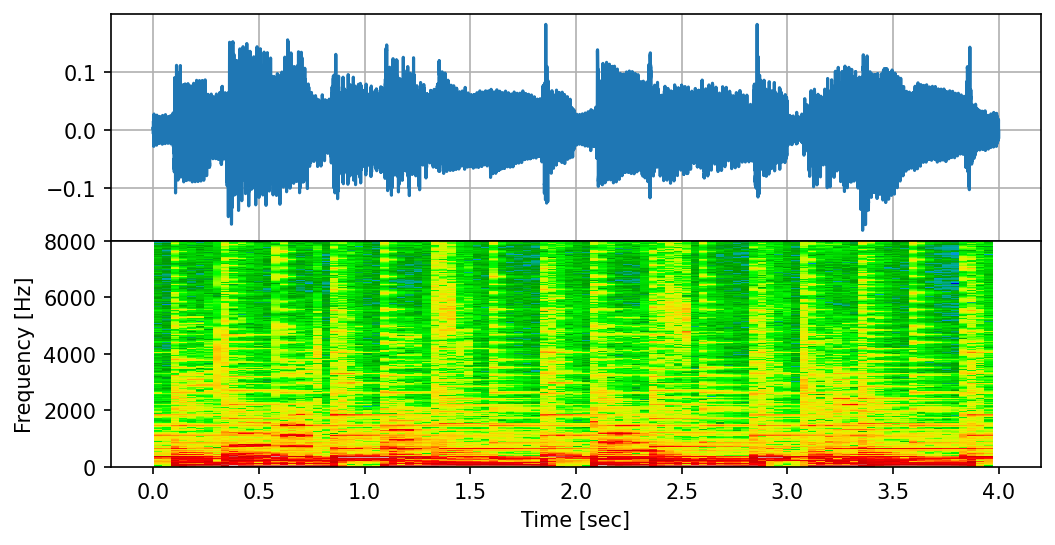

In [143]:
micro = 3
show_sound(sources.dot(mixing[:, micro]))

In [145]:
micros = sources.dot(mixing)

micros

array([[-2.36535918e-05,  8.91444963e-04,  8.91444963e-04,
         2.69798848e-03],
       [ 3.21314136e-04,  1.23793451e-03,  1.23793451e-03,
         3.39248940e-03],
       [ 6.06565945e-04,  1.53368140e-03,  1.53368140e-03,
         3.99447826e-03],
       ...,
       [-3.81176498e-03, -3.09916473e-03, -3.48387456e-03,
        -5.58190666e-03],
       [-3.89600838e-03, -2.64944890e-03, -3.03415873e-03,
        -4.14851577e-03],
       [-2.30263796e-03, -1.64400446e-03, -2.02052898e-03,
        -2.72350655e-03]])

In [153]:
from sklearn.decomposition import FastICA, PCA

# decomposition = PCA()
decomposition = FastICA()
decomposition.fit(micros)

FastICA()

In [154]:
restored_sources = decomposition.transform(micros)

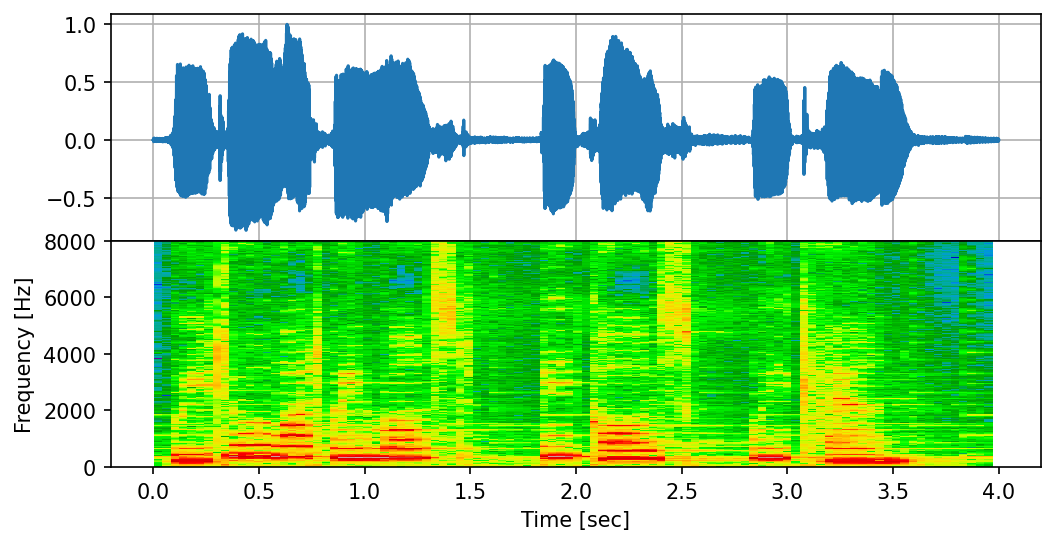

In [161]:
source = 0
show_sound(restored_sources[:, source]/np.max(np.abs(restored_sources[:,source])))

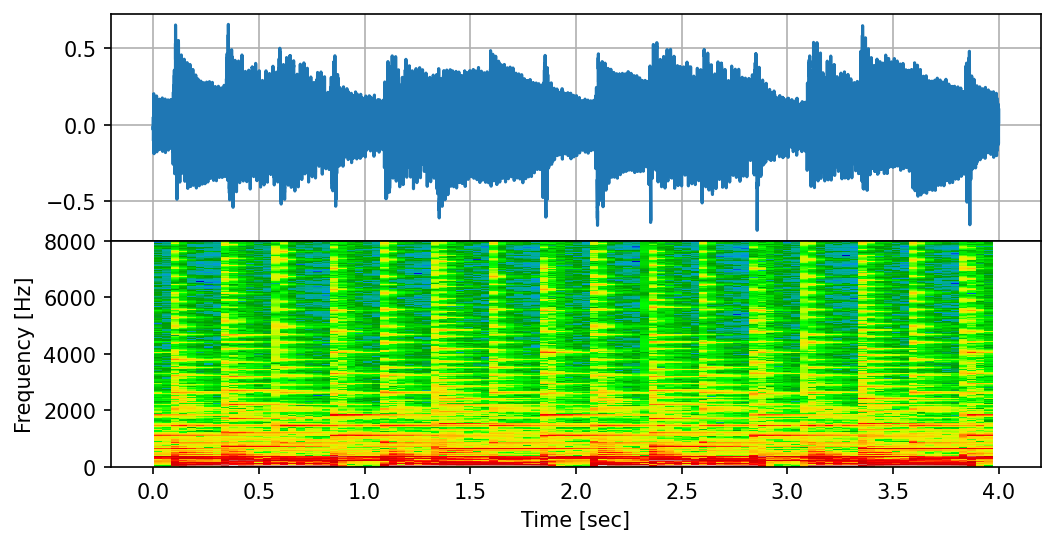

In [162]:
minus = np.sum([restored_sources[:, s]/np.max(restored_sources[:,s]) for s in range(4) if s!=source], 0)/3

show_sound(minus)

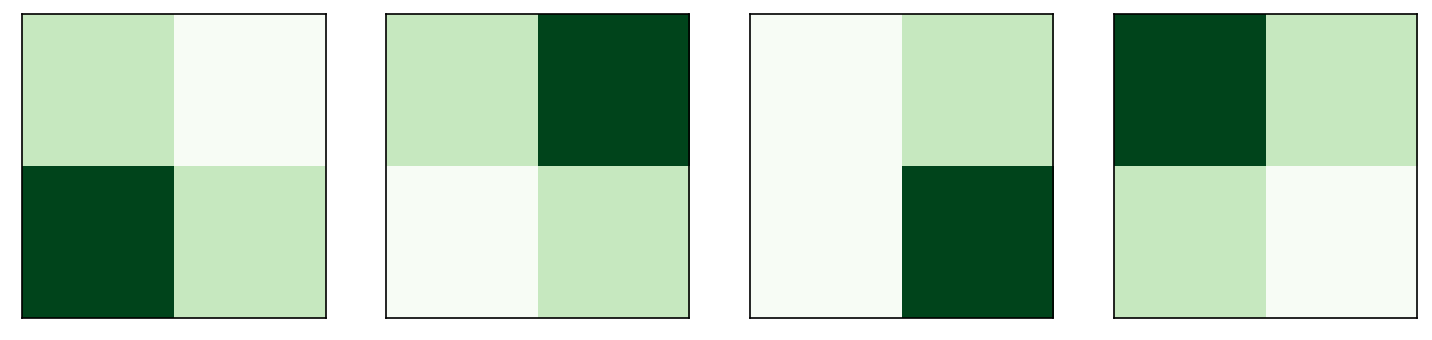

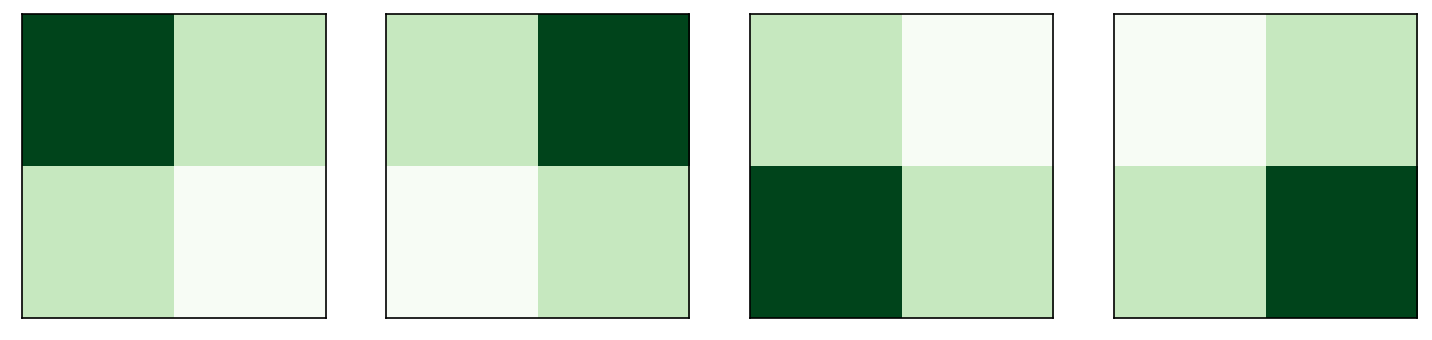

In [160]:
mixing_restored = decomposition.mixing_.copy()
# mixing_restored = decomposition.components_.copy()

for k in range(len(mixing_restored)):
    col = mixing_restored[:, k]
    col_abs_max_with_sign = col[np.argmax(np.abs(col))]
    mixing_restored[:, k] /= col_abs_max_with_sign

mixing_restored *= 0.5
mixing_restored = np.round(mixing_restored, 1)


plot_top(mixing_restored)
plot_top(mixing)

In [120]:
display(mixing_restored)
display(mixing)

array([[-0.3, -0.4,  0.4, -0.2],
       [-0. ,  0.5,  0.5, -0. ],
       [ 0.5, -0.2,  0.2, -0.2],
       [ 0.1, -0.3,  0.2,  0.5]])

array([[0.5, 0.2, 0.2, 0.1],
       [0.2, 0.5, 0.1, 0.2],
       [0.2, 0.1, 0.5, 0.2],
       [0.1, 0.2, 0.2, 0.5]])

In [101]:
np.argmax(np.abs(decomposition.mixing_), 0)

array([1, 2, 3, 0])

In [102]:
decomposition.mixing_

array([[-11.48891972,  10.62408804,   0.79030296,  21.86225794],
       [-28.77796193,   5.4044387 ,   1.78171327,   9.11271154],
       [ -5.88319447,  26.5200413 ,   1.62287568,   8.72605509],
       [-11.7049649 ,  10.59124971,   5.91113385,   4.57585153]])

In [105]:
mixing_restored[:, np.argmax(np.abs(decomposition.mixing_), 0)]

array([[13.44305737,  0.03614919, -1.90289936, -1.08140291],
       [ 3.03328195,  0.19551955, -0.3166559 , -5.32487526],
       [16.34138804,  0.18598045, -1.48321718, -0.22183957],
       [ 1.79174588,  1.29181067, -0.39093253, -1.10515428]])